# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.


## Task 1: Dependencies and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [1]:
!pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121

We'll need an OpenAI API Key:

In [16]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

And the LangSmith set-up:

In [2]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Week 8 Assignment 1 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

Let's verify our project so we can leverage it in LangSmith later.

In [3]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Week 8 Assignment 1 - c2efa5c6


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

In [5]:
from google.colab import files
uploaded = files.upload()

ModuleNotFoundError: No module named 'google.colab'

In [25]:
file_path = list(uploaded.keys())[0]
file_path

'eu_ai_act (1).html'

In [4]:
file_path = ("Wright, G. R. T., Berry, C. J., Catmur, C., & Bird, G. (2015). Good Liars Are Neither ‘Dark’ Nor Self-Deceptive..pdf")

We'll define our chunking strategy.

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [6]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [21]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings

# Typical Embedding Model
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Typical QDrant Client Set-up
collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# Adding cache!
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!<br>
<br>
*Limitations*<br>
 - Storage Size: The cache is stored locally (in ./cache/), which could become problematic if the cache size grows significantly due to a large number of embeddings. Handling a large cache would require substantial disk space and could also lead to slower retrieval if not managed efficiently.
 - Cache Misses: The cache can only improve efficiency if the same documents or similar queries are used frequently. For new or unique data, the cache will not have precomputed embeddings, resulting in a cache miss, and embeddings need to be computed from scratch.
 - Potential Staleness: If documents are updated or the embedding model is retrained, the cache may contain outdated embeddings, leading to inconsistencies. The system needs a mechanism to invalidate or refresh the cache in such situations.
<br>

*When It's Most Useful*
 - Repetitive Embedding Queries: This approach is most useful when dealing with frequently queried documents or embeddings. If many queries involve similar or the same documents, the cache will save computation time, making the system faster and more efficient.
 - Development and Prototyping: It is also helpful during development and prototyping when experimenting with embeddings repeatedly, as caching can reduce computation times considerably.
 - Non-Distributed, Small-Scale Applications: The local file storage approach works well in a small-scale environment where all data can be managed locally and the embeddings remain relatively static.
<br>

*When It's Least Useful*
 - Highly Dynamic Content: If the documents or data are updated frequently, caching might not be very effective, as the cached embeddings would become obsolete quickly, requiring recomputation.
 - Low Repetition in Queries: If each query involves unique or new data that hasn't been cached, then the cache offers little to no advantage, as it won't help reduce computation.
 - Scalable/Distributed Environments: In distributed setups where different nodes or services need to share the embeddings, a local file cache isn't feasible. In such cases, a distributed caching solution like Redis or using a persistent centralized database would be more appropriate.

##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [22]:
import time
from langchain.embeddings import CacheBackedEmbeddings
from langchain.storage import LocalFileStore

# Step 3: Test Without Cache
print("Testing without cache:")
start_time = time.time()
for _ in range(3):  # Run the embedding computation multiple times for comparison
    embeddings_without_cache = [core_embeddings.embed_query(doc.page_content) for doc in docs]
end_time = time.time()
no_cache_duration = end_time - start_time
print(f"Time taken without cache: {no_cache_duration:.4f} seconds")



Testing without cache:
Time taken without cache: 49.2526 seconds


In [24]:
# Step 4: Adding Cache
print("\nTesting with cache:")
# store = LocalFileStore("./cache/")
# cached_embedder = CacheBackedEmbeddings.from_bytes_store(core_embeddings, store, namespace=core_embeddings.model)

# Step 5: Test With Cache
start_time = time.time()
for _ in range(3):  # Run the embedding computation multiple times for comparison
    embeddings_with_cache = [cached_embedder.embed_query(doc.page_content) for doc in docs]
end_time = time.time()
cache_duration = end_time - start_time
print(f"Time taken with cache: {cache_duration:.4f} seconds")

# Step 6: Conclusion
improvement = no_cache_duration - cache_duration
print("\nSummary:")
print(f"Cache improvement: {improvement:.4f} seconds")


Testing with cache:
Time taken with cache: 36.7180 seconds

Summary:
Cache improvement: 12.5345 seconds


### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [25]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [26]:
from langchain_core.globals import set_llm_cache
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini")

Setting up the cache can be done as follows:

In [27]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

#### Limitations of Cached Prompt Approach

1. **Limited to Identical Queries**:
   - Caching is only effective for repeated, identical queries. If there are slight variations in the input (e.g., different contexts or questions), the cache will not be used, leading to no performance improvement.

2. **Memory Consumption**:
   - The cache can consume significant memory if many queries are stored, especially when dealing with larger models or high-volume use cases. This can lead to increased hardware requirements or performance bottlenecks.

3. **Stale Responses**:
   - Cached responses may become outdated if the underlying information changes. If the application requires up-to-date or real-time responses, relying on cached prompts may provide inaccurate results.

4. **Increased Complexity**:
   - Implementing caching adds complexity to the system. Developers need to handle cache invalidation and manage storage efficiently to avoid issues like incorrect or expired data being served.

5. **Limited Use with Personalized Data**:
   - For use cases involving personalization or sensitive information, caching can be inappropriate. It may result in serving the wrong data to the wrong user, leading to privacy concerns.

#### When Cached Prompt is Most Useful

1. **High Query Repetition**:
   - Caching is most beneficial in scenarios where the same questions are frequently repeated, such as FAQ systems, customer support bots, or common knowledge retrieval tasks.

2. **Reducing Costs and Latency**:
   - In cases where latency is a critical factor (e.g., real-time applications) or when reducing API costs is important, caching can significantly decrease the response time and lower the number of calls to the model.

3. **Batch Processing**:
   - When processing a large volume of identical queries, such as during automated testing or when many users are likely to ask the same question, caching helps to reduce computational overhead.

#### When Cached Prompt is Least Useful

1. **Highly Dynamic Queries**:
   - If each query is unique or if the input changes frequently, caching provides little to no benefit. Examples include personalized recommendations, dynamic question answering based on user-specific data, or creative content generation.

2. **Low Repetition Rate**:
   - In cases where users rarely ask the same question, caching becomes redundant, as there is no repeated input to benefit from. In such instances, the cache would remain mostly unused, adding unnecessary complexity.

3. **Real-Time or Constantly Updated Data**:
   - Applications that rely on the most recent data, such as financial updates, news aggregation, or live reports, require fresh content. Cached prompts could provide stale or irrelevant information, making them less useful in such contexts.


##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

In [34]:
# Define a sample input
sample_question = "What is the capital of France?"
sample_context = "France is a country in Europe."

# Function to evaluate response time
def measure_response_time(chat_model, question, context):
    start_time = time.time()
    _ = chat_model(chat_prompt.format_prompt(question=question, context=context).to_messages())
    end_time = time.time()
    return end_time - start_time

# Experiment with caching enabled
set_llm_cache(InMemoryCache())  # Enable caching
cached_chat_model = ChatOpenAI(model="gpt-4o-mini")

# Experiment without caching
set_llm_cache(None)  # Disable caching
non_cached_chat_model = ChatOpenAI(model="gpt-4o-mini")

# Perform the experiment
# num_iterations = 10
cached_times = []
non_cached_times = []

# for _ in range(num_iterations):
    # Measure response time for cached model
cached_time = measure_response_time(cached_chat_model, sample_question, sample_context)

# Measure response time for non-cached model
non_cached_time = measure_response_time(non_cached_chat_model, sample_question, sample_context)

# Display results
print(f"Response time with cache: {cached_time:.4f} seconds")
print(f"Response time without cache: {non_cached_time:.4f} seconds")


Response time with cache: 0.5867 seconds
Response time without cache: 0.6529 seconds


## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [35]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

Let's test it out!

In [36]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

AIMessage(content='1. The document is titled "Good Liars Are Neither ‘Dark’ Nor Self-Deceptive."\n2. It was authored by Gordon R. T. Wright, Christopher J. Berry, Caroline Catmur, and Geoffrey Bird.\n3. The document was created on May 28, 2015.\n4. It is in PDF format, version 1.4.\n5. The document spans a total of 11 pages.\n6. It discusses the psychology of lying and the traits of effective liars.\n7. The authors argue that good liars do not possess \'dark\' personality traits.\n8. The document includes references to various psychological studies on deception.\n9. It mentions the DeceIT task, a method used to study deceitful behavior.\n10. The authors utilized a False-Opinion Paradigm in their research.\n11. The document refers to a "Social Opinion Questionnaire" used to gather ground truth.\n12. It explores how personal goals can influence the acceptability of deceit.\n13. The DeceIT paradigm was administered on 9-inch tablet PCs for the study.\n14. Participants\' responses were col

In [38]:
from langchain_core.globals import get_llm_cache
print(get_llm_cache())

None


In [39]:


# Set up LLM cache
set_llm_cache(InMemoryCache())

# Retrieval augmented QA chain with cache-backed LLM calls
cached_retrieval_augmented_qa_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | chat_prompt
    | chat_model  # Cache-backed LLM call using chat_model
)

cached_retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

AIMessage(content='1. The document is a PDF titled "Good Liars Are Neither ‘Dark’ Nor Self-Deceptive".\n2. It was authored by Gordon R. T. Wright, Christopher J. Berry, Caroline Catmur, and Geoffrey Bird.\n3. The document was published in 2015.\n4. It consists of 11 total pages.\n5. The PDF format is 1.4.\n6. The document\'s creation date is May 28, 2015.\n7. The last modification date is also May 28, 2015.\n8. The document is associated with the Economic and Social Research Council (ESRC).\n9. It discusses the psychology of lying and deception.\n10. The authors conducted an experiment using a False-Opinion Paradigm.\n11. The DeceIT task is referenced in the document.\n12. Participants used 9-inch tablet PCs for the experiment.\n13. A "Social Opinion Questionnaire" was part of the experimental procedure.\n14. Topics in the questionnaire included censorship of the media and nuclear power.\n15. The document cites various studies and articles related to deception.\n16. It mentions Frank a

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

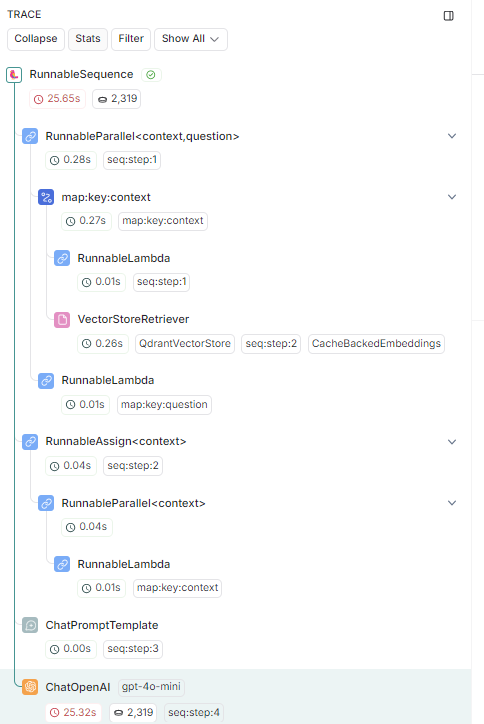

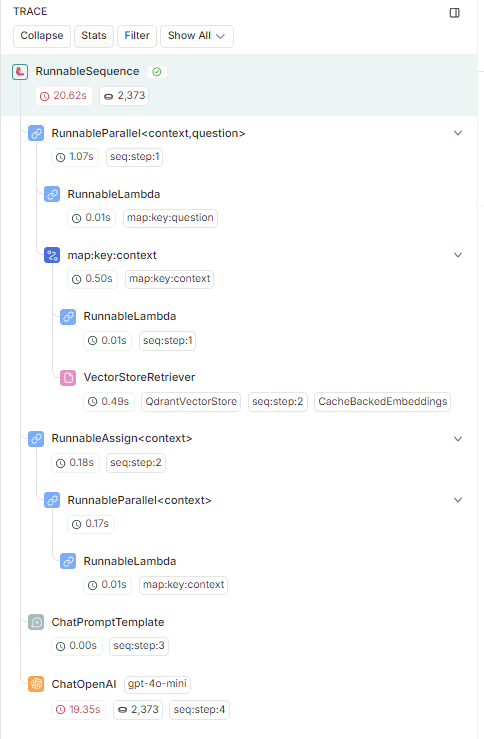